In [1]:
import stats
import compare_vcf as comp
from read_vcf import parse_vcf
import re
import numpy as np
import matplotlib.pyplot as plt

try: 
    data = [parse_vcf(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf') for i in range(1, 11)]

# Generate fixed files if needed (fix coverage = None sniffle error)
except FileNotFoundError:
    pattern = r'(COVERAGE=[^;]*)(None)([^;]*;)'
    replacement = r'\g<1>0\g<3>'

    for i in range(1, 11):
        with open(f'data-p90/P90-{i}.trimed1000.sv_sniffles.vcf', 'r') as infile:
            file_contents = infile.read()

        modified_contents = re.sub(pattern, replacement, file_contents)

        with open(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf', 'w') as outfile:
            outfile.write(modified_contents)
    
    data = [parse_vcf(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf') for i in range(1, 11)]


### Plot basic statistics on variants

#### Merge naif : une variations présente à l'identique dans plusieurs échantillons est compté pour chaque occurence

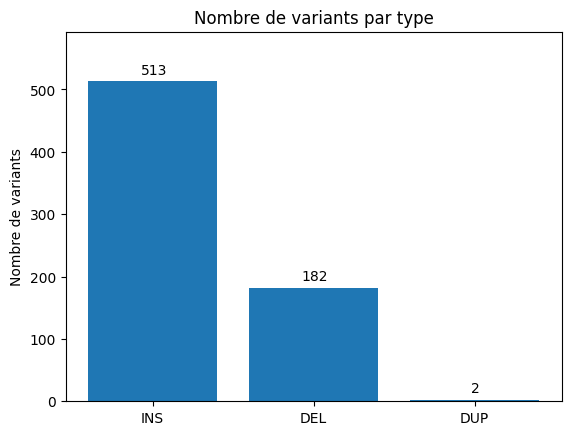

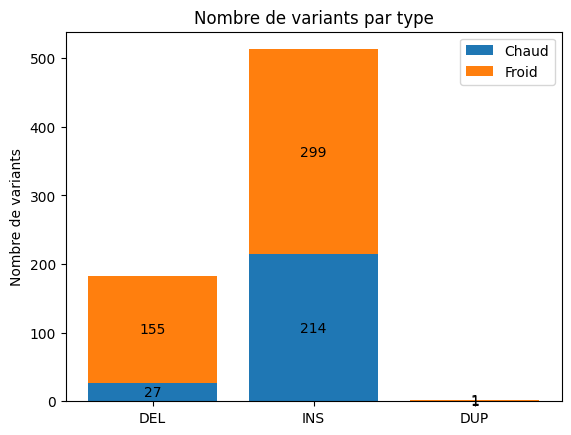

In [2]:
all_variant = sum(data, [])
heat_group = sum([data[i] for i in range(0, 4)], [])
cold_group = sum([data[i] for i in range(4, 10)], [])

counts_all = stats.count_types([v["svtype"] for v in all_variant])
counts_heat = stats.count_types([v["svtype"] for v in heat_group])
counts_cold = stats.count_types([v["svtype"] for v in cold_group])

grouped_labels = list( set(counts_heat.keys()).union(counts_heat.keys()) )
grouped_counts = {
    "Chaud": [counts_heat[k] if k in counts_heat else 0 for k in grouped_labels],
    "Froid": [counts_cold[k] if k in counts_cold else 0 for k in grouped_labels]
}

stats.plot_count_by_type(counts_all)
stats.plot_grouped_count_by_type(grouped_counts, grouped_labels)

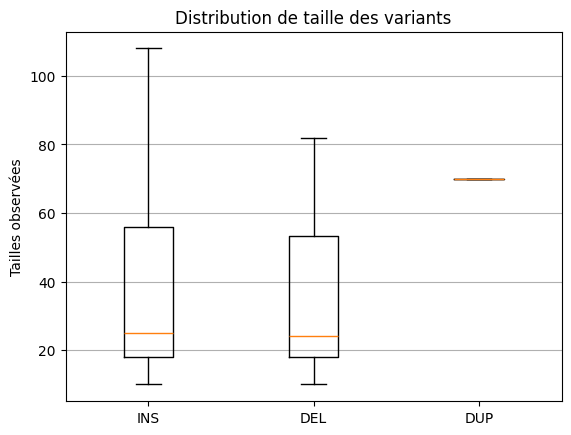

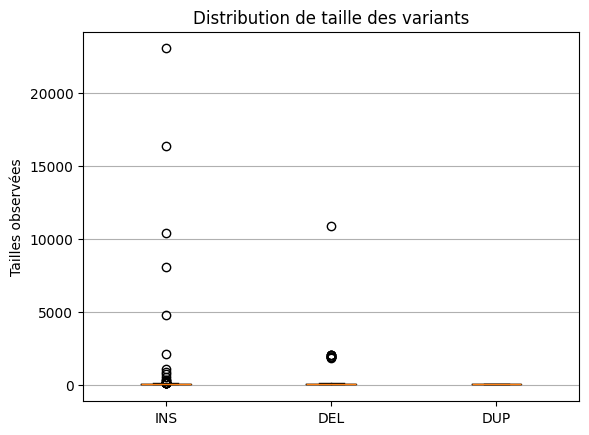

In [3]:
len_distrib_all = stats.len_by_type([(v["svtype"], v["svlen"]) for v in all_variant])
stats.plot_len_by_type(len_distrib_all, False)
stats.plot_len_by_type(len_distrib_all, True)

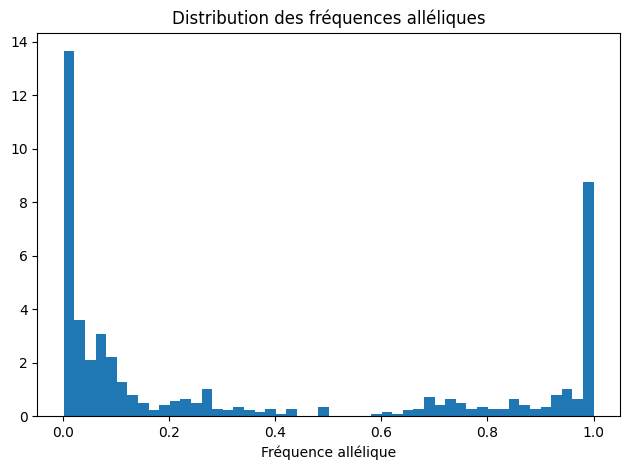

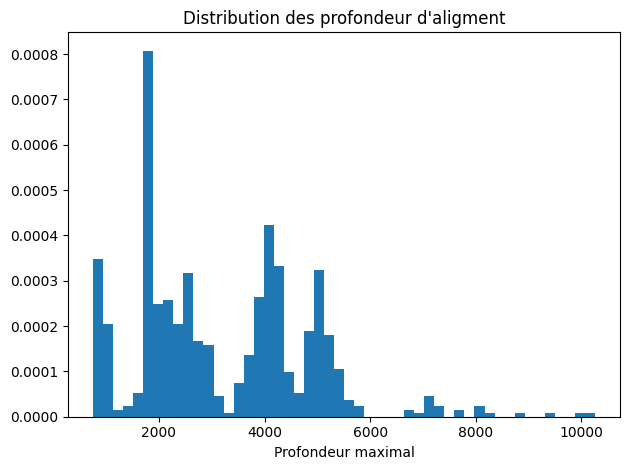

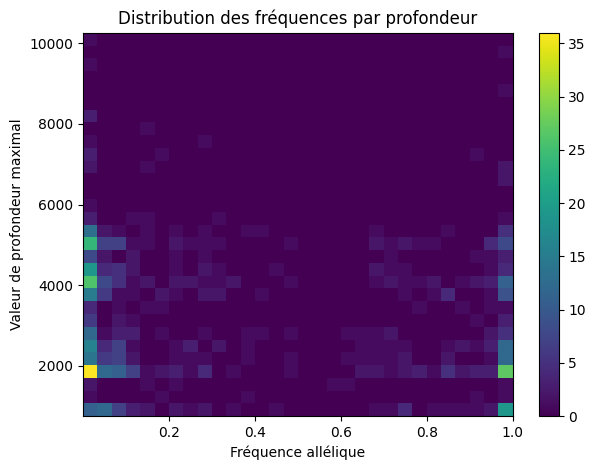

In [ ]:
af = [v["af"] for v in all_variant]
depth = [max(v["depth"]) for v in all_variant]

fig, ax = plt.subplots()
ax.hist(af, bins=50)
ax.set_xlabel('Fréquence allélique')
ax.set_title("Distribution des fréquences alléliques")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.hist(depth, bins=50)
ax.set_xlabel('Profondeur maximal')
ax.set_title("Distribution des profondeur d'aligment")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
h = ax.hist2d(af, depth, bins=(30, 30))
fig.colorbar(h[3], ax=ax)

ax.set_xlabel('Fréquence allélique')
ax.set_ylabel('Valeur de profondeur maximal')
ax.set_title("Distribution des fréquences par profondeur")
fig.tight_layout()
plt.show()

#### Merge avancé : une variation présente à l'identique dans deux échantillons n'est compté qu'une fois

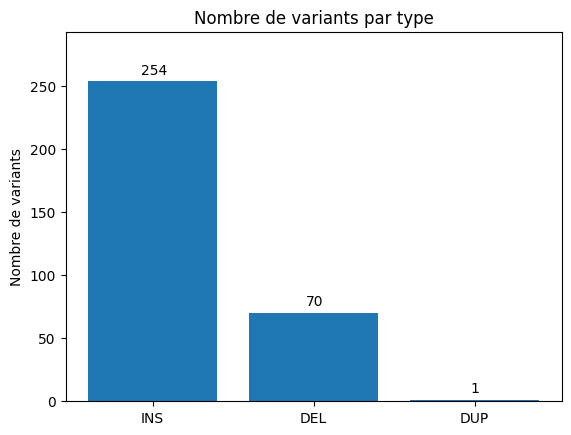

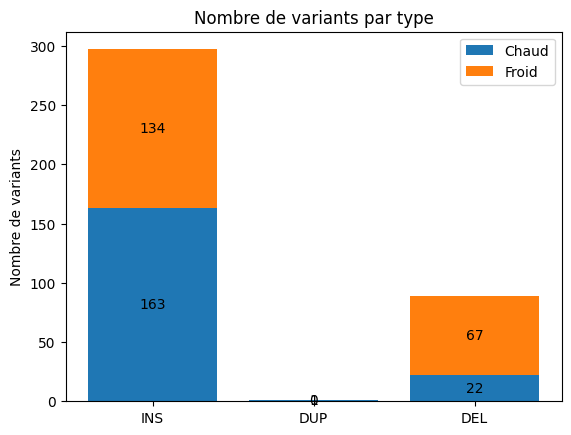

In [5]:
thresold = 1
all_variant_2 = comp.merge_samples(data, sim_thresold=thresold)
heat_group_2 = comp.merge_samples(data[0:5], sim_thresold=thresold)
cold_group_2 = comp.merge_samples(data[5:10], sim_thresold=thresold)

counts_all_2 = stats.count_types([grp[0][1]["svtype"] for grp in all_variant_2])
counts_heat_2 = stats.count_types([grp[0][1]["svtype"] for grp in heat_group_2])
counts_cold_2 = stats.count_types([grp[0][1]["svtype"] for grp in cold_group_2])

grouped_labels_2 = list( set(counts_heat.keys()).union(counts_heat.keys()) )
grouped_counts_2 = {
    "Chaud": [counts_heat_2[k] if k in counts_heat_2 else 0 for k in grouped_labels],
    "Froid": [counts_cold_2[k] if k in counts_cold_2 else 0 for k in grouped_labels]
}

stats.plot_count_by_type(counts_all_2)
stats.plot_grouped_count_by_type(grouped_counts_2, grouped_labels_2)

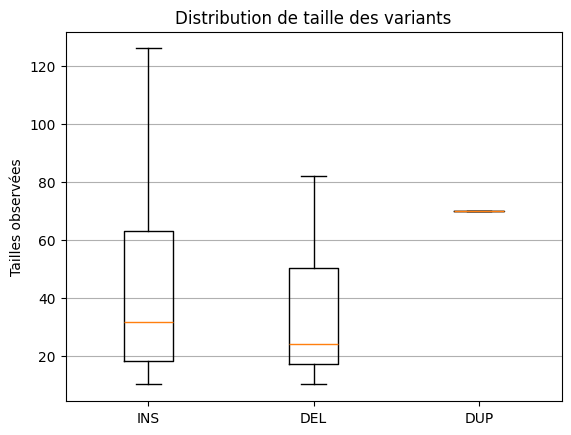

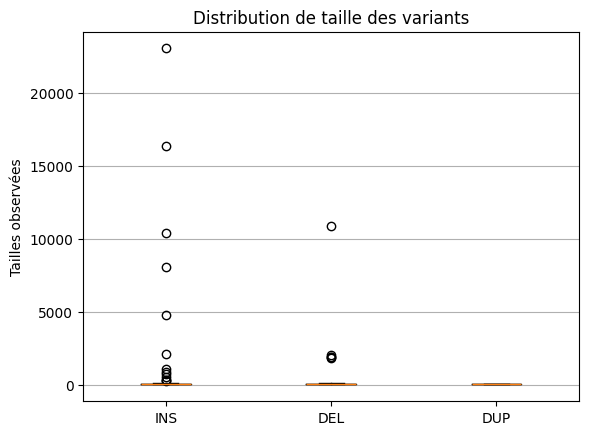

In [6]:
len_distrib_all_2 = stats.len_by_type([(grp[0][1]["svtype"], np.mean([x[1]["svlen"] for x in grp])) for grp in all_variant_2])
stats.plot_len_by_type(len_distrib_all_2, False)
stats.plot_len_by_type(len_distrib_all_2, True)

### Plot similarity heatmap between samples

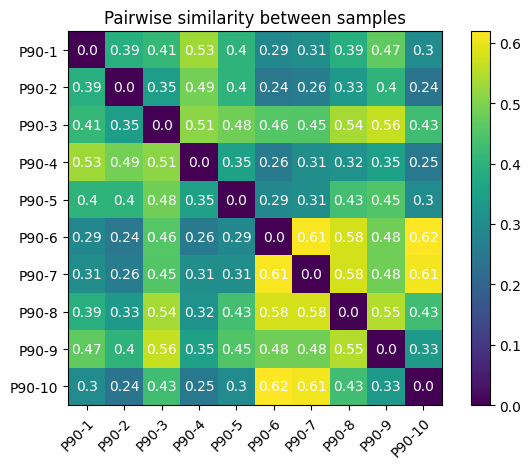

In [7]:
grouped_data = comp.merge_samples(data, sim_thresold=1)
sims = comp.pairwise_similarity(list(range(0, 10)), grouped_data)
comp.variant_heatmap(sims, [f"P90-{i}" for i in range(1, 11)])